In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import ipdb
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
from scipy.stats import binom, norm

from protein_conformal.util import *

In [3]:
# conformal_pfam.npy is a len 10,000 list of dictionaries of len 10,000 hits. 
# This isn't the most valid way to do this, because it incoporates proteins from the training set into calibration. 
# We chose to do this because the previous approach didn't have enough new examples to calibrate.
data = np.load('/data/ron/protein-conformal/data/conformal_pfam_with_lookup_dataset.npy', allow_pickle=True)
len(data)
len(data[0]['S_i'])

10000

## Look at distribution of S_i across retrieved hits

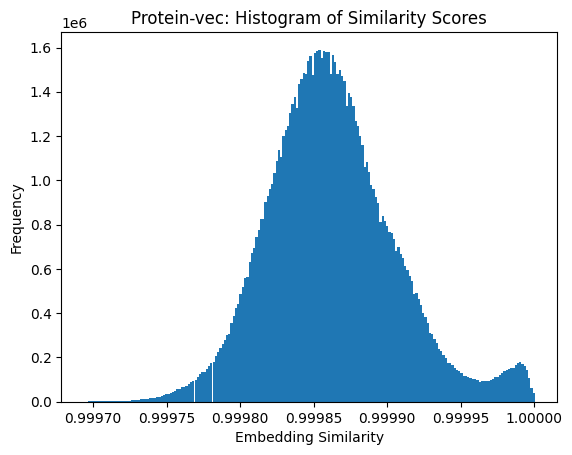

In [25]:
sims = np.stack([query['S_i'] for query in data], axis=0)
plt.hist(sims.flatten(), bins=200)
plt.xlabel('Embedding Similarity')
plt.ylabel('Frequency')
plt.title('Protein-vec: Histogram of Similarity Scores')
plt.show()

## FDR for exact hits on Pfam

In [3]:
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([query['exact'] for query in data], axis=0)
sims = np.stack([query['S_i'] for query in data], axis=0)


In [ ]:
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
# percentage_of_discoveries_rsk = [percentage_of_discoveries(sims, labels, lam) for lam in lambdas]

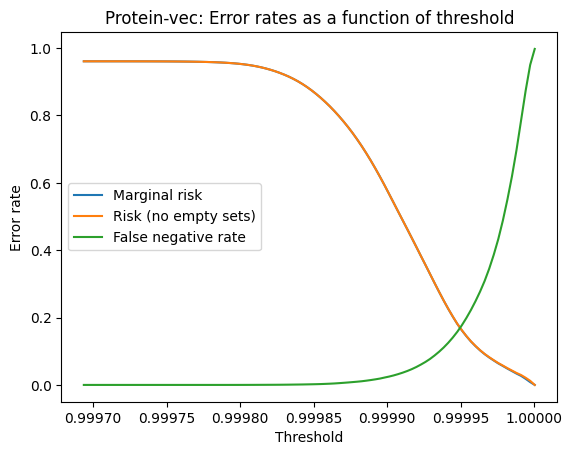

In [17]:
# Plot FDR + FNR as a function of lambda
plt.figure()
plt.plot(lambdas, risks, label='Marginal risk')
plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.title('Protein-vec: Error rates as a function of threshold')
plt.legend()
plt.show()

## FDR / FNR on partial hits on Pfam

In [51]:
# Plot FDR as a function of lambda
sims, labels_partial = get_sims_labels(data, partial=True)
# labels_partial = np.stack([(np.sum(query['partial'], axis=1) >= 1) if len(np.array(query['partial']).shape) > 1 else query['partial'] for query in data], axis=0)
# sims = np.stack([query['S_i'] for query in data], axis=0)
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels_partial, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels_partial, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels_partial, lam) for lam in lambdas]

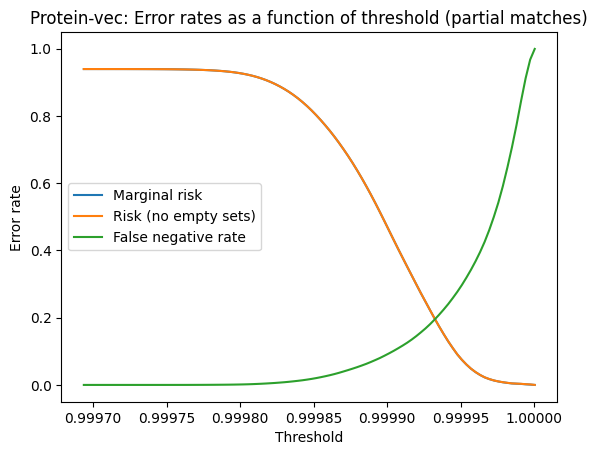

In [53]:
# Plot FDR + FNR as a function of lambda
plt.plot(lambdas, risks, label='Marginal risk')
plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.title('Protein-vec: Error rates as a function of threshold (partial matches)')
plt.legend()

## Learn then test for FDR

In [4]:
alpha = 0.1
# TODO; /data/ron/protein-conformal/protein_conformal/util.py:79: RuntimeWarning: divide by zero encountered in double_scalars
# z = (r_hat - alpha) / (std_hat / np.sqrt(n))
lhat = get_thresh_FDR(labels, sims, alpha, delta=0.5, N=100)

sims.max: 1.0000004768371582


/data/ron/protein-conformal/protein_conformal/util.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  z = (r_hat - alpha) / (std_hat / np.sqrt(n))


lhat: 0.9999663962258233
risk: 0.09136092572122927


In [5]:
num_trials = 2
alpha = 0.1
n_calib = 5000
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:]
    lhat = get_thresh(cal_data, alpha)
    error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)
    # TODO: add lhat to print
    # TODO: difference between get_thresh and get_thresh_FDR
    print(f'Trial {trial+1}: Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')
    

Trial 1: Ex&!Id/Ex: 0.10, In/Id: 0.45, Pa&!Id/Pa: 0.30, Pa&Id/Id: 0.66
Trial 2: Ex&!Id/Ex: 0.09, In/Id: 0.47, Pa&!Id/Pa: 0.28, Pa&Id/Id: 0.64
Trial 3: Ex&!Id/Ex: 0.10, In/Id: 0.45, Pa&!Id/Pa: 0.30, Pa&Id/Id: 0.66
Trial 4: Ex&!Id/Ex: 0.10, In/Id: 0.44, Pa&!Id/Pa: 0.30, Pa&Id/Id: 0.67
Trial 5: Ex&!Id/Ex: 0.10, In/Id: 0.44, Pa&!Id/Pa: 0.30, Pa&Id/Id: 0.67
Trial 6: Ex&!Id/Ex: 0.10, In/Id: 0.46, Pa&!Id/Pa: 0.30, Pa&Id/Id: 0.66
Trial 7: Ex&!Id/Ex: 0.10, In/Id: 0.44, Pa&!Id/Pa: 0.29, Pa&Id/Id: 0.67
Trial 8: Ex&!Id/Ex: 0.09, In/Id: 0.46, Pa&!Id/Pa: 0.29, Pa&Id/Id: 0.65
Trial 9: Ex&!Id/Ex: 0.10, In/Id: 0.44, Pa&!Id/Pa: 0.30, Pa&Id/Id: 0.66
Trial 10: Ex&!Id/Ex: 0.11, In/Id: 0.42, Pa&!Id/Pa: 0.30, Pa&Id/Id: 0.68


## Venn-Abers prediction

In [8]:
sims[:n_calib, :].shape

(50, 10000)

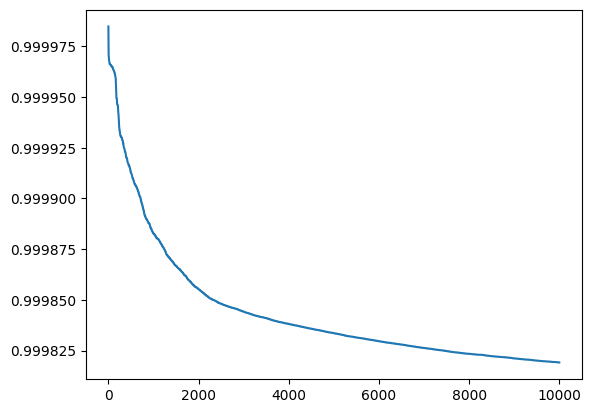

In [9]:
plt.plot(sims[:n_calib, :][0])

In [19]:
# Venn-Abers prediction
from util import simplifed_venn_abers_prediction

n_calib = 50
# np.random.shuffle(data)
X_cal = sims[:n_calib, :].flatten()
y_cal = labels[:n_calib].flatten()
# cal_data = data[:n_calib]
X_test = sims[n_calib:2*n_calib, :].flatten()
y_test = labels[n_calib:2*n_calib].flatten()
# test_data = data[n_calib:3*n_calib]
# ir = get_isotone_regression(cal_data)
# sims, labels = get_sims_labels(test_data, partial=False)
p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, y_test[0])

# preds = ir.predict(sims)
# g = sns.JointGrid()
# g.ax_joint.scatter(sims, labels, alpha=0.003)
# x = np.linspace(min(sims), max(sims), 1000)
# phats = ir.predict(x)
# g.ax_joint.plot(x, phats)
# g.ax_marg_x.hist(np.array(sims)[np.array(labels)], label='1', alpha=0.5)
# g.ax_marg_x.hist(np.array(sims)[~np.array(labels)], label='0', alpha=0.5)
# plt.show()

500000
500000
(500000,)
(500000,)


In [20]:
p_0, p_1

(1.0, 0.994709)

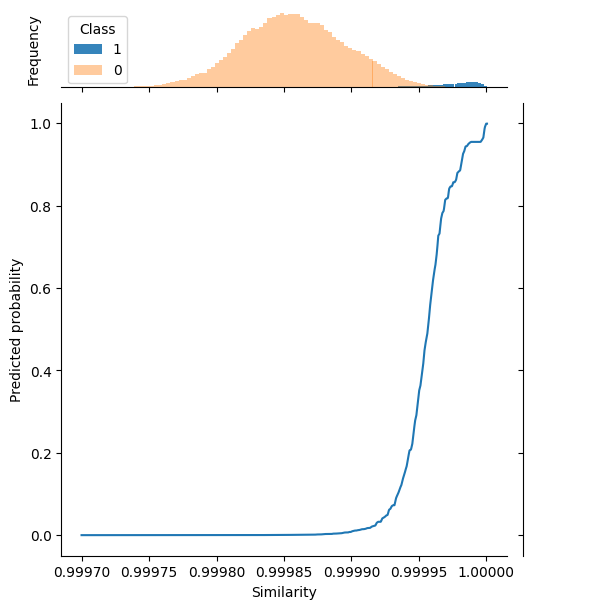

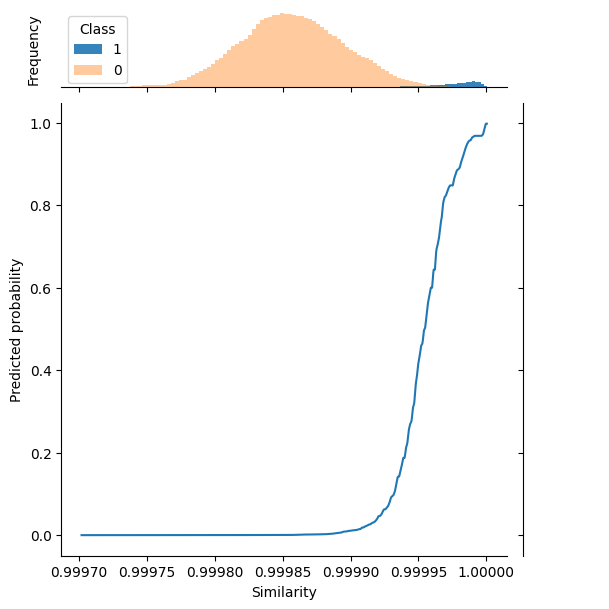

In [50]:
num_trials = 2
n_calib = 1200
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:2*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    ir = get_isotone_regression(X_cal.flatten(), y_cal.flatten())
    X_test, y_test = get_sims_labels(test_data, partial=False)
    preds = ir.predict(X_test.flatten())
    g = sns.JointGrid()
    # g.ax_joint.scatter(X_test[y_test], y_test[y_test], alpha=0.002)
    # g.ax_joint.scatter(X_test[~y_test], y_test[~y_test], alpha=0.002)
    x = np.linspace(np.min(X_test), np.max(X_test), 1000)
    phats = ir.predict(x)
    g.ax_joint.plot(x, phats)
    g.set_axis_labels('Similarity', 'Predicted probability')

    g.ax_marg_x.hist(X_test[y_test], label='1', alpha=0.9, bins=100)
    g.ax_marg_x.hist(X_test[~y_test], label='0', alpha=0.4, bins=100)
    # Manually create a new axis for the marginal histogram and set its y-axis label
    ax_marg_y = g.figure.add_axes(g.ax_marg_x.get_position())
    ax_marg_y.yaxis.tick_right()
    ax_marg_y.set_ylabel('Frequency', labelpad=15)
    ax_marg_y.yaxis.set_label_position('left')
    ax_marg_y.set_yticks([])
    ax_marg_y.set_frame_on(False)
    ax_marg_y.set_xticks([])

    handles, labels = g.ax_marg_x.get_legend_handles_labels()
    g.ax_marg_x.legend(handles, labels, title='Class')

    # Optionally remove the spines for a cleaner look
    # g.ax_marg_x.spines['bottom'].set_visible(False)
    # g.ax_marg_x.spines['top'].set_visible(False)
    # g.ax_marg_x.spines['left'].set_visible(False)
    # g.ax_marg_x.spines['right'].set_visible(False)
    
    plt.show()
    
    ##print()
    #plt.figure()
    #sim_bins = np.linspace(min(sims), max(sims), 100)
    #plt.hist(np.array(sims)[np.array(labels)], bins=sim_bins, alpha=0.5, label='1')
    #plt.hist(np.array(sims)[~np.array(labels)], bins=sim_bins, alpha=0.5, label='0')
    #plt.legend()

    

## Scratch

In [ ]:
np.argmax([sum(query['exact'])/len(query['exact']) for query in data])

In [ ]:
sum(data[843]['exact'])

In [ ]:
np.median([sum(query['exact'])/len(query['exact']) for query in data])

In [ ]:
# rename the D_i key in data to S_i and save the file
for i in range(len(data)):
    data[i]['S_i'] = data[i].pop('D_i')
np.save('/data/ron/protein-conformal/data/conformal_pfam.npy', data)

In [ ]:
# conformal_pfam.npy is a len 1864 list of dictionaries of len 1000. 
# We stopped using this because for some proteins, every retreived hit was a true positive.
# TODO: can remake this dataset with 10000 retrieved hits per protein. 
# This is more accurate than the solution after, which samples generally from the lookup set instead.

data = np.load('/data/ron/protein-conformal/data/conformal_pfam.npy', allow_pickle=True)
len(data)

1864

In [ ]:
data[0].keys()

dict_keys(['meta', 'meta_query', 'exact', 'partial', 'D_i'])

'meta': these are the Pfam (protein family) entries from the lookup dataset. Len 1000

'meta_query': this is the Pfam of the query protein (there is only one per dict). Some proteins will have multiple pfams associated with them

'exact': True if the meta_query Pfam is in any of the Pfams for meta. Len 1000

'partial': In the case where a query protein is assigned multiple Pfams, we seek to see if we get partial hits for each of these query protein Pfams. Shape 1000 x # of Pfams for query protein

D_i: These are the similarities assigned by our model for each query to its top 1000 lookup pairs (len 1000 as well)

(array([  2069.,  12248.,  38818., 133427., 247517., 230022., 159742.,
         97177.,  23181.,   1361.]),
 array([0.99980909, 0.99982811, 0.99984714, 0.99986616, 0.99988519,
        0.99990422, 0.99992324, 0.99994227, 0.99996129, 0.99998032,
        0.99999934]),
 <BarContainer object of 10 artists>)

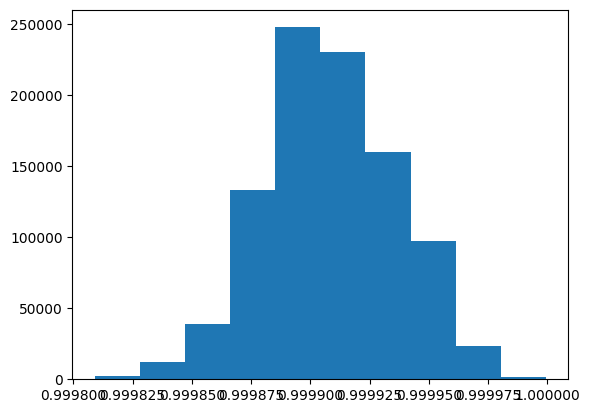

In [ ]:
plt.hist(np.array(sims)[~np.array(labels).astype(bool)])

In [ ]:
ir.predict(sims)

array([1.00000000e+00, 1.00000000e+00, 9.11538462e-01, ...,
       2.08751924e-04, 2.08751924e-04, 2.08751924e-04])

In [ ]:
ir.predict([.5])

array([0.])

In [ ]:
# I believe this was to look at the histogram of 
sims, labels = get_sims_labels(test_data, partial=False)
plt.hist(np.array(sims)[np.array(labels).astype(bool)])

KeyError: 'D_i'

In [ ]:
max_sim_exact = []
for i in range(len(data[0]['exact'])):
    idx = data[0]['exact'][i]
    sims = data[0]['S_i'][i]

    max_sim = sims[idx]
    max_sim_exact.append(max(sims[idx]))

ValueError: max() arg is an empty sequence

In [ ]:
    # for lookup in query['exact']:
    #     sims = query['D_i']
    #     all_sim_exact.append(sims[lookup])

# for i in range(len(data['exact'])):
#     idx = data['exact'][i]
#     sims = data['D_i'][i]
#     sims_to_append = sims[idx]
#     # if len(sims_to_append) == 0:
#     #     sims_to_append = np.nan
#     all_sim_exact.append(sims_to_append)